
# TP Autoencodeur 


L'objectif de ce TP consiste à créer un auto-codeur pré-entraîné pour apprendre la représentation condensée initiale des jeux de données non étiquetés. Cette architecture est composée en 3 parties : 
- **Encodeur :** compresse les données d'entrée de l'ensemble train-validation-test dans une représentation codée qui est généralement plus petite de plusieurs ordres de grandeur que les données d'entrée
- **Espace latent :** espace qui contient les représentations de connaissances comprimées et qui est donc la partie la plus importante du réseau.
- **Décodeur :** Un module qui aide le réseau à "décompresser" les représentations de la connaissance et à reconstruire les données à partir de leur forme codée. La sortie est ensuite comparée à une vérité de terrain.



In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input, Layer, InputSpec,  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.initializers import VarianceScaling

from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Chargement des données 

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

import numpy as np

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))



11490434/11490434 [==============================] - 2s 0us/step


## Autoencodeur : version classique

In [3]:
# Dimension de l'entrée
input_img = Input(shape=(784,))

# Dimension de l'espace latent : PARAMETRE A TESTER !!
latent_dim = 10

# Définition du encodeur
x0 = Dense(300, activation='relu')(input_img)
x = Dense(100, activation='relu')(x0)
encoded = Dense(latent_dim, activation='relu')(x)


# Définition du décodeur
decoder_input = Input(shape=(latent_dim,))
x = Dense(100, activation='relu')(decoder_input)
x1 = Dense(300, activation='relu')(x)
decoded = Dense(784, activation='relu')(x1)

# Construction d'un modèle séparé pour pouvoir accéder aux décodeur et encodeur
encoder = Model(input_img, encoded)
decoder = Model(decoder_input, decoded)


# Construction du modèle de l'auto-encodeur
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)



In [4]:
# Autoencodeur 
autoencoder.compile(optimizer='Adam', loss='mse')
autoencoder.summary()
print(encoder.summary())
print(decoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 model (Functional)          (None, 10)                266610    
                                                                 
 model_1 (Functional)        (None, 784)               267384    
                                                                 
Total params: 533,994
Trainable params: 533,994
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 30

In [5]:
autoencoder.fit(x_train,x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test,x_test))

Epoch 1/20
469/469 [==============================] - 7s 8ms/step - loss: 0.0382 - val_loss: 0.0278
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0259 - val_loss: 0.0242
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0236 - val_loss: 0.0226
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0220 - val_loss: 0.0213
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0211 - val_loss: 0.0207
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0205 - val_loss: 0.0203
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0190 - val_loss: 0.0190

In [6]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


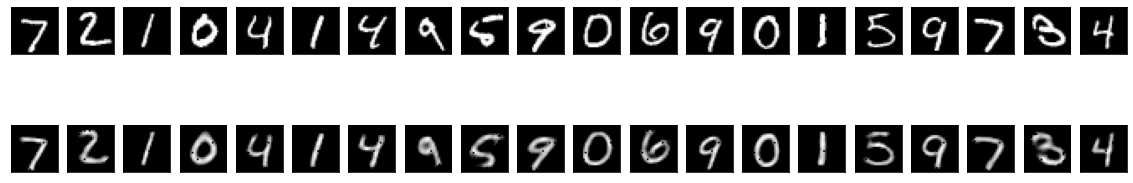

In [7]:
n = 20  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

32/32 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


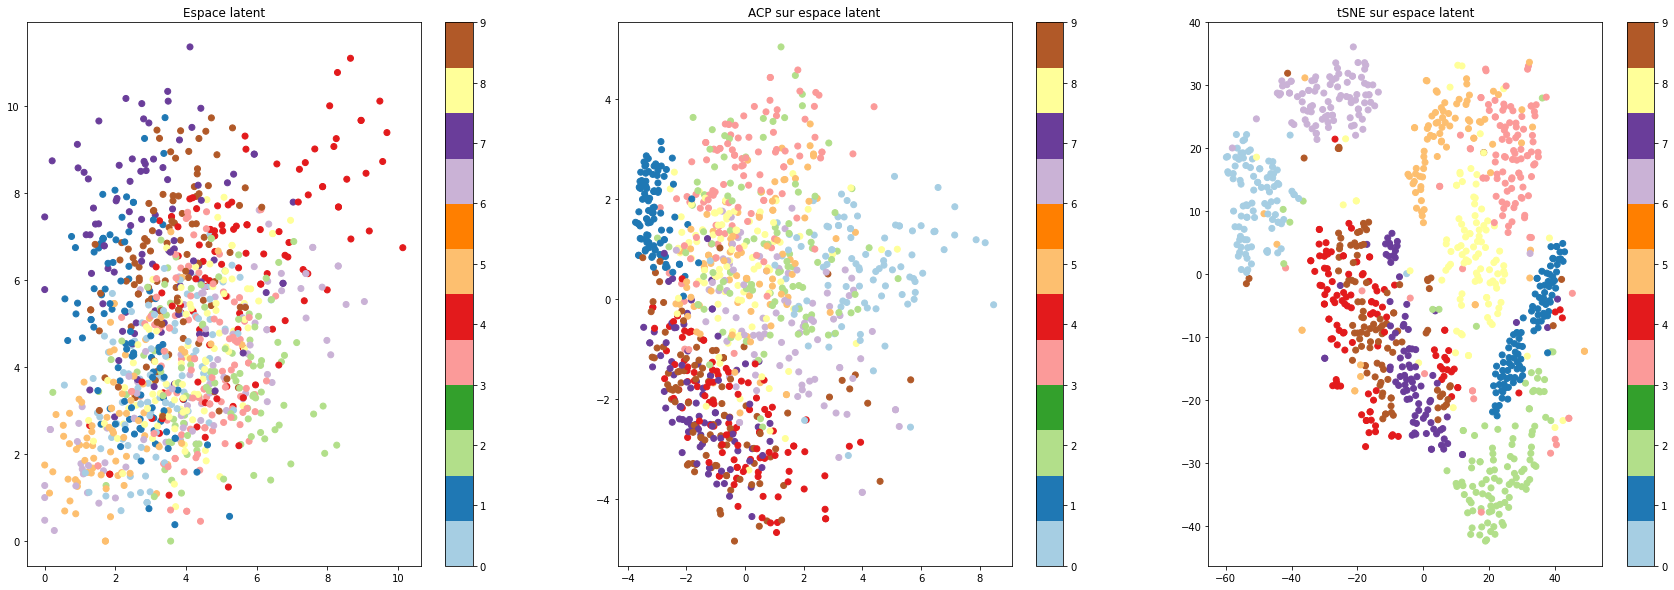

In [8]:
# Affichage
count=1000
idx = np.random.choice(len(x_test), count)
inputs = x_test[idx]

coordsAC = encoder.predict(inputs)
coordsTSNE = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))
coordsPCA = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))



classes = y_test[idx]

fig= plt.figure(figsize=(30, 10))
ax=plt.subplot(1,3,1)
ax.set_title("Espace latent")
plt.scatter(coordsAC[:, 0], coordsAC[:, 1], c=classes, cmap='Paired')
plt.colorbar()

ax= plt.subplot(1,3,2)
ax.set_title("ACP sur espace latent")
plt.scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=classes,cmap='Paired')
plt.colorbar()



ax = plt.subplot(1,3,3)
ax.set_title("tSNE sur espace latent")
plt.scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=classes,cmap='Paired')
plt.colorbar()